In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from analysis import *
import pickle as pkl

In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
tensorflow.keras.utils.pydot = pyd

In [3]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [4]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


In [5]:
n = 1000
x = np.arange(n)
y = Electric.Load.to_numpy()[-n:]

1. Split sequences to 80% train set and 20% test set

In [6]:
train_ratio = 0.8
train_len = int(train_ratio * x.shape[0])
print(train_len)

800


2. Detrending

In [31]:
y_trend = linear_fit(x=x, y=y)
y_detrend = y - y_trend

x_trend_param = np.polyfit(y[:train_len], x[:train_len], 1)

3. Combine sequences

In [8]:
x_lbl = np.column_stack([y_detrend, x, [1]*train_len+[0]*(len(x)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 3)
[[ 4.11627115e+03  0.00000000e+00  1.00000000e+00]
 [ 4.13519443e+03  1.00000000e+00  1.00000000e+00]
 [ 4.09461772e+03  2.00000000e+00  1.00000000e+00]
 ...
 [-2.09661672e+03  9.97000000e+02  0.00000000e+00]
 [-2.27999343e+03  9.98000000e+02  0.00000000e+00]
 [-2.55127015e+03  9.99000000e+02  0.00000000e+00]]


4. Normalize

In [9]:
x_train_max = x_lbl[x_lbl[:, 2]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]  # only normalize for the first 2 columns
print(x_train_max)

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[5959.762323838328, 799.0, 1]
[[ 0.69067707  0.          1.        ]
 [ 0.69385224  0.00125156  1.        ]
 [ 0.68704379  0.00250313  1.        ]
 ...
 [-0.35179536  1.24780976  0.        ]
 [-0.38256449  1.24906133  0.        ]
 [-0.42808253  1.25031289  0.        ]]


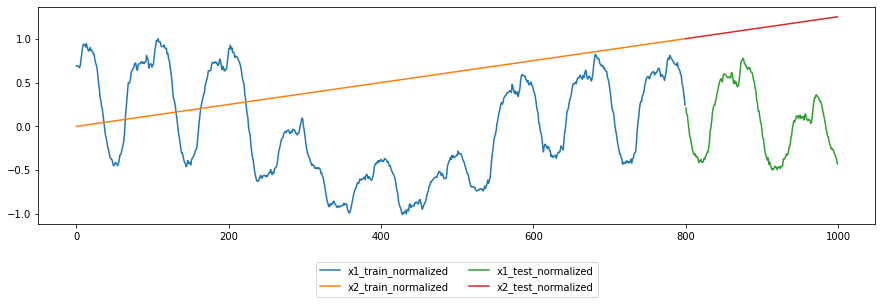

In [10]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

5. Truncate

In [11]:
def truncate(x, feature_cols=range(2), target_cols=range(2), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(2), target_cols=range(2), 
                            label_col=2, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 2) (781, 20, 2) (781,)


In [12]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 2) (600, 20, 2)
(181, 200, 2) (181, 20, 2)


In [36]:
data = {
    'X_input_train': X_input_train, 
    'X_output_train': X_output_train, 
    'X_input_test': X_input_test, 
    'X_output_test': X_output_test,
    'X_trend': y_trend,
    'x_trend_param': x_trend_param,
    'x_train_max': x_train_max
         }


pkl.dump(data, open('../Data/data.pkl', 'wb'))

Model

In [14]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [15]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [16]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1) 
print(encoder_last_h1)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")


In [17]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [18]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [19]:
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [20]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [21]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        40800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 batch_normalization (BatchNorm  (None, 100)         400         ['lstm[0][0]']                   
 alization)                                                                                   

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [24]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :1], X_output_train[:, :, :1], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 7s 557ms/step - loss: 6.9412 - mae: 1.4208 - val_loss: 0.2676 - val_mae: 0.4578
Epoch 2/100
5/5 [==============================] - 2s 404ms/step - loss: 1.2057 - mae: 0.7067 - val_loss: 0.1227 - val_mae: 0.2791
Epoch 3/100
5/5 [==============================] - 2s 395ms/step - loss: 0.2131 - mae: 0.3486 - val_loss: 0.1516 - val_mae: 0.3164
Epoch 4/100
5/5 [==============================] - 2s 403ms/step - loss: 0.1152 - mae: 0.2651 - val_loss: 0.1403 - val_mae: 0.2818
Epoch 5/100
5/5 [==============================] - 2s 400ms/step - loss: 0.0985 - mae: 0.2420 - val_loss: 0.1110 - val_mae: 0.2768
Epoch 6/100
5/5 [==============================] - 2s 403ms/step - loss: 0.0919 - mae: 0.2350 - val_loss: 0.1115 - val_mae: 0.2751
Epoch 7/100
5/5 [==============================] - 2s 412ms/step - loss: 0.0733 - mae: 0.2093 - val_loss: 0.0990 - val_mae: 0.2277
Epoch 8/100
5/5 [==============================] - 2s 409ms/step - loss: 0.0803 - m

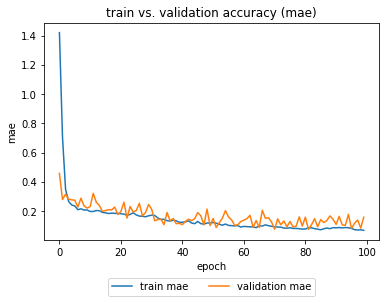

In [25]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Predict

In [26]:
train_pred_detrend = model.predict(X_input_train[:, :, :1])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :1])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :1]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :1]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [28]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 1], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 1], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [34]:
x_trend_param

array([-1.15370852e-02,  6.16201407e+02])

In [38]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x = dt[:, :, 0] + (dt[:, :, 1]**2)*x_trend_param[0] + dt[:, :, 1]*x_trend_param[1]
    data_final[lb] = np.expand_dims(dt_x, axis=2)

print(lb+': {}'.format(data_final[lb].shape))

test_true: (181, 20, 1)


In [39]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
499862.9941370413
maximum: train_true
454775.80561044294
maximum: test_pred
426374.80666246574
maximum: test_true
382385.44668696466


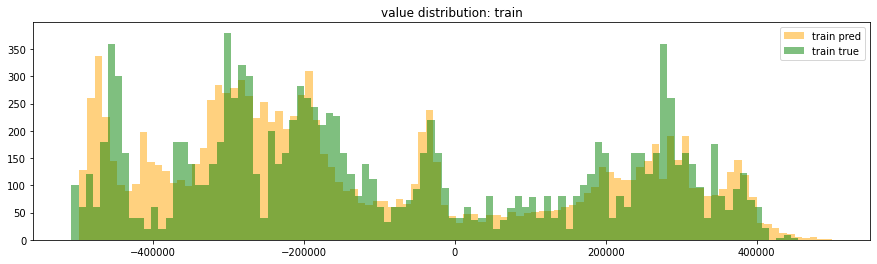

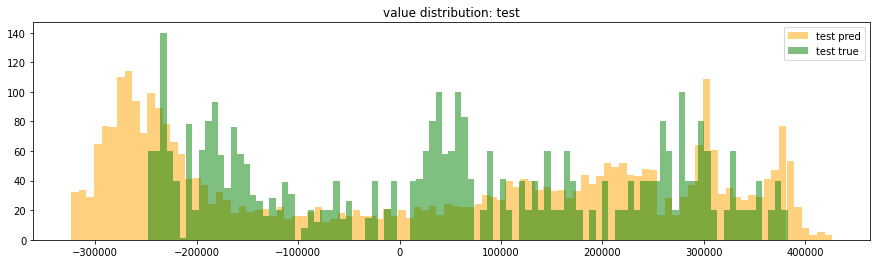

In [40]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

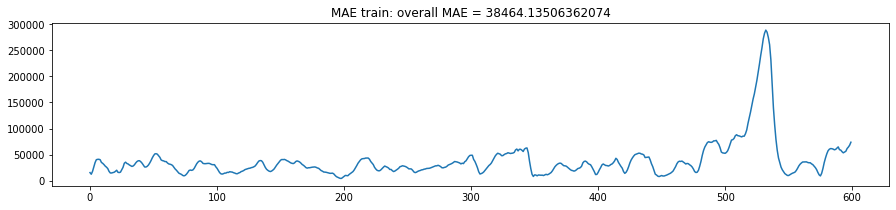

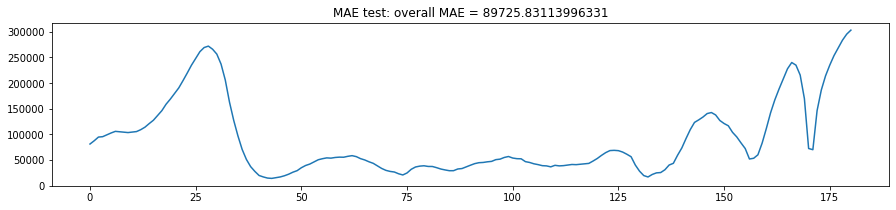

In [41]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

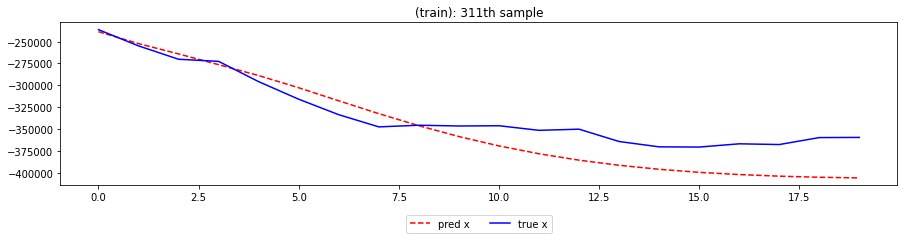

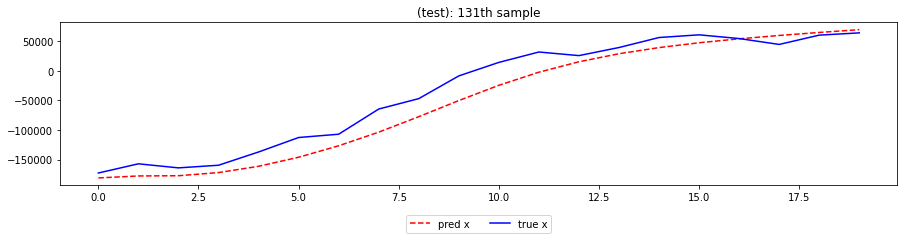

In [48]:
import random

for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    plt.plot(data_final[lb+'_pred'][ith_sample, :, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][ith_sample, :, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

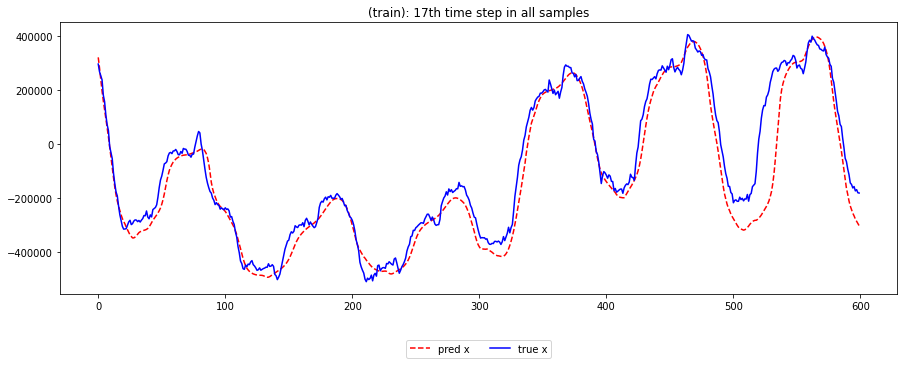

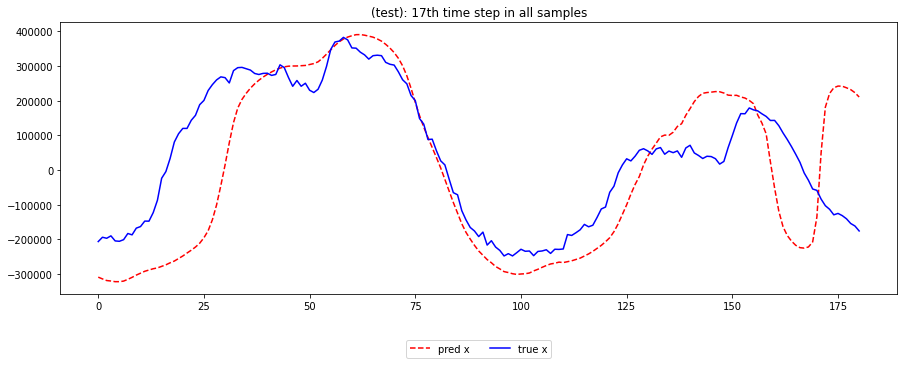

In [47]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
for lb in ['train', 'test']:   
    plt.figure(figsize=(15, 5))
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, 0], linestyle='--', color='r', label='pred x')
    plt.plot(data_final[lb+'_true'][:, ith_timestep, 0], linestyle='-', color='b', label='true x')
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

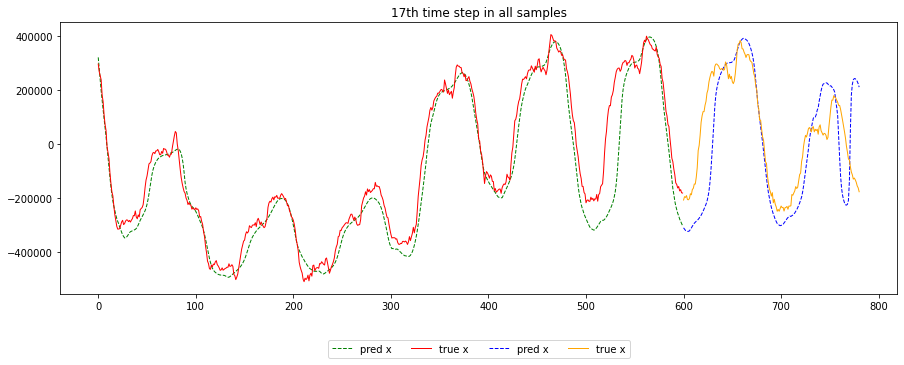

In [52]:
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                data_final[lb+'_pred'][:, ith_timestep, 0], 
                linestyle='--', linewidth=1, color=clrs[0], label='pred x')
    plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                data_final[lb+'_true'][:, ith_timestep, 0], 
                linestyle='-', linewidth=1, color=clrs[1], label='true x')
    
    
plt.title(f'{ith_timestep}th time step in all samples')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()